# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**


Данные геологоразведки трёх регионов находятся в файлах:


1./datasets/geo_data_0.csv. 


2./datasets/geo_data_1.csv. 


3./datasets/geo_data_2.csv.


id — уникальный идентификатор скважины;


f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);


product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

Начнем с импорта необходимых  далее инструментов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

Взглянем на наши данные

In [2]:
df0=pd.read_csv('/datasets/geo_data_0.csv')
df1=pd.read_csv('/datasets/geo_data_1.csv')
df2=pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df0.sample(10)

,id,f0,f1,f2,product
25583,5gId1,-0.617696,0.585473,1.649965,87.621597
22981,GiLEa,1.410532,-0.216008,8.619650,103.101680
75266,MfSF0,2.141823,0.058284,7.607081,69.622214
62893,3vFWW,1.930458,0.178593,-3.391506,52.112651
22503,RXRyw,0.200801,1.023091,5.932752,162.720124
46044,COptR,0.660373,0.760111,0.984949,39.683799
56578,3WIal,0.963981,-0.422071,2.161607,68.497821
59829,o7LX2,0.784828,-0.414184,-0.728532,54.994745
94774,1z6lL,-0.126125,0.392554,1.741346,169.861557
31507,r3qaB,0.227488,0.892798,3.408907,115.854946


In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропущеных значений нет, предобоработка будет значительно проще.

Оценим также коэффициенты корреляции между будущими признаками и целевым значением.

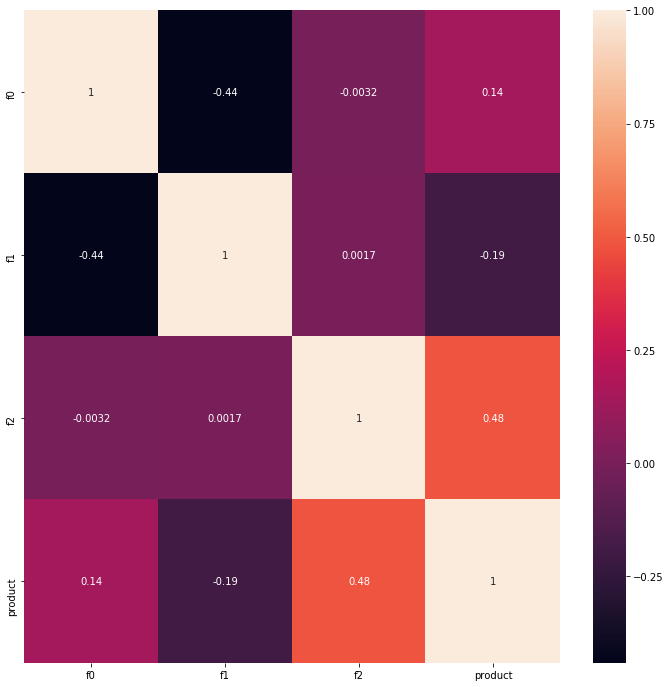

In [5]:
corr = df0.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

In [6]:
df0.corr()['product'].reset_index().sort_values(by='product',ascending=False).reset_index(drop=True)

,index,product
0,product,1.000000
1,f2,0.483663
2,f0,0.143536
3,f1,-0.192356


Самый большой вес имеет признак f2.

In [7]:
df1.sample(10)

,id,f0,f1,f2,product
69991,5p4hn,-0.037392,-9.836442,0.995040,30.132364
38123,qloMt,8.075835,-1.529117,3.998434,107.813044
94825,m4x9M,-9.230093,-9.468007,3.007329,84.038886
9207,yohOi,-6.060217,-13.094070,4.004837,110.992147
41706,S1TYs,13.175620,-10.757609,-0.004119,0.000000
29396,zhQzy,1.200676,-0.730021,4.991626,137.945408
65817,qDERy,-13.448667,-10.665397,0.001296,3.179103
69055,tae07,1.272586,-6.071984,5.001800,137.945408
35032,CTI42,2.734302,-8.829775,2.000651,53.906522
6829,mnxob,-2.338773,-1.219533,4.002040,110.992147


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


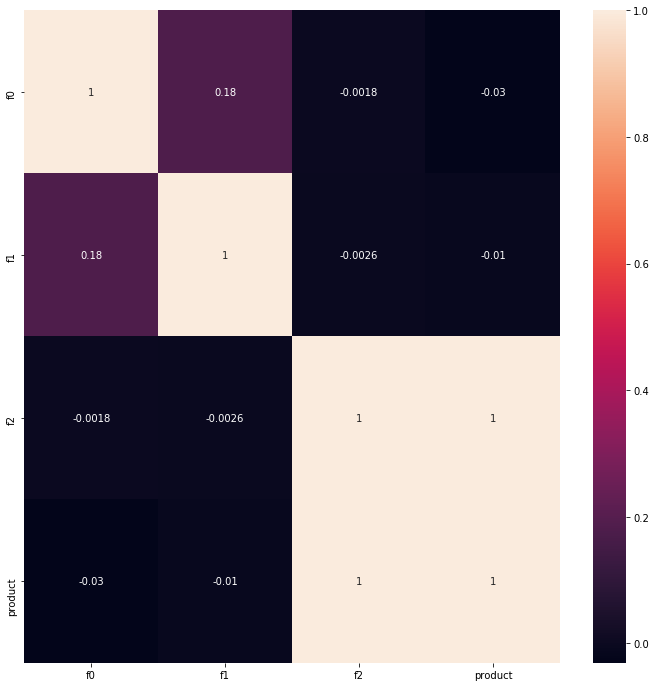

In [9]:
corr = df1.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

In [10]:
df1.corr()['product'].reset_index().sort_values(by='product',ascending=False).reset_index(drop=True)

,index,product
0,product,1.000000
1,f2,0.999397
2,f1,-0.010155
3,f0,-0.030491


Тенденция в данных по второму участку разработки сохраняется, пропусков нет, корреляция f2 самая сильная. В отличие от первого набора данных, в этом коэффициент корреляции с признаком f2 достигает практически еденицы, что говорит нам об очень сильной зависимости целевого значения от этого признака. Это очень хорошо для будущей модели, так как такая взаимосвязь поможет  делать более точные предсказания и минимизировать ошибку.

Проверим, наконец, третий набор данных

In [11]:
df2.sample(10)

,id,f0,f1,f2,product
32070,zrNkc,-1.472374,-2.428712,4.262405,111.773054
46167,x63YG,1.070984,-1.630796,-2.760530,30.148644
69233,itBRJ,-0.006453,0.759495,4.677694,152.225770
51473,ZSpYE,-0.654985,1.453234,1.971594,89.577327
51569,b6KjA,0.088191,0.264014,-3.580746,62.024390
20294,vRPkP,1.242063,1.141407,5.775092,75.540303
49722,Go6hQ,-1.996159,-0.495210,-1.037883,55.592633
98692,mX69s,0.142501,0.102018,3.592291,119.608566
70155,uT1xs,-0.309745,-0.350607,0.488368,63.520403
69009,x91IK,-0.426900,-1.672110,3.105829,93.411546


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


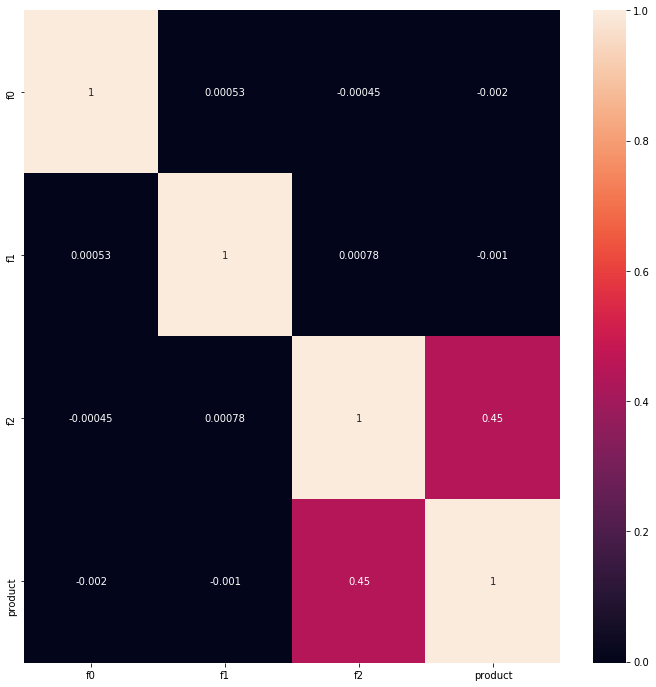

In [13]:
corr = df2.corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

In [14]:
df2.corr()['product'].reset_index().sort_values(by='product',ascending=False).reset_index(drop=True)

,index,product
0,product,1.000000
1,f2,0.445871
2,f1,-0.001012
3,f0,-0.001987


Третий набор данных больше похож на первый, нежели на второй. Однако, все данные поступили в удобном для работы с ними виде и не требуют предобработки.

Проверим наборы данных на наличие дубликатов.

In [15]:
df0.duplicated().sum()

0

In [16]:
df1.duplicated().sum()

0

In [17]:
df2.duplicated().sum()

0

 Для упрощения последующего построения модели графу 'id' во всех наборах отбросим.

In [18]:
df0=df0.drop(['id'], axis=1)
df1=df1.drop(['id'], axis=1)
df2=df2.drop(['id'], axis=1)

После этого шага можно приступать к построению модели

## Обучение и проверка модели

Определим признаки и целевое значение для всех трёх наборов данных

In [19]:
features_0 = df0.drop(['product'], axis=1)
target_0 = df0['product']
features_1 = df1.drop(['product'], axis=1)
target_1 = df1['product']
features_2 = df2.drop(['product'], axis=1)
target_2 = df2['product']

Теперь разделим полученные выборки на обучающие и валидационные в соотношении 75:25

In [20]:
features_train_0,  features_valid_0,target_train_0, target_valid_0 = train_test_split(features_0, target_0,
                    test_size=0.25, random_state=42)
features_train_1,  features_valid_1,target_train_1, target_valid_1 = train_test_split(features_1, target_1,
                    test_size=0.25, random_state=42)
features_train_2,  features_valid_2,target_train_2, target_valid_2 = train_test_split(features_2, target_2,
                    test_size=0.25, random_state=42)

Проверим правильность разбиения

In [21]:
print(features_train_0.shape, target_train_0.shape, features_valid_0.shape, target_valid_0.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


In [22]:
print(features_train_1.shape, target_train_1.shape, features_valid_1.shape, target_valid_1.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


In [23]:
print(features_train_2.shape, target_train_2.shape, features_valid_2.shape, target_valid_2.shape)

(75000, 3) (75000,) (25000, 3) (25000,)


Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). Запускаме модель и прогоняем её по трем наборам данных, получая предсказания объёма разработки. Для наглядности создадим сравнительную таблицу, содержащую в себе истинное и предсказанное значения. Оценим также среднее предсказанное среднеквадратичную ошибку(для упрощения восприятия сразу извлечем квадратный корень)

In [24]:
def reg_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions_sorted=pd.Series(predictions).sort_values(ascending=False).reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    result = pd.DataFrame(target_valid).join(pd.DataFrame(predictions), how='inner')
    result.columns = ['true_values', 'predicted_values']
    display(result.sort_values('predicted_values', ascending=False))
    print('Cреднее предсказанное',result['predicted_values'].mean(), ", RSME ", mean_squared_error(target_valid,
                                                                        predictions)**0.5)
    return result, predictions, target_valid

In [25]:
result_0, predictions_0, target_valid_0 = reg_model(features_train_0, target_train_0, features_valid_0, target_valid_0)

,true_values,predicted_values
6958,153.639837,176.536104
18194,140.631646,176.274510
17251,178.879516,173.249504
457,176.807828,172.802708
2202,130.985681,172.744977
...,...,...
24951,49.374929,9.986965
8613,40.181343,9.867996
11880,25.956984,8.503684
6966,11.018692,4.600630


Cреднее предсказанное 92.39879990657768 , RSME  37.75660035026169


Достаточно большое значение ошибки, однако, не говорит нам о непригодности модели. Прежде, чем делать какие-либо выводы, проведем такой же эксперимент для всех наборов данных и сравним полученные значения.

In [26]:
result_1, predictions_1, target_valid_1 = reg_model(features_train_1, target_train_1, features_valid_1, target_valid_1)

,true_values,predicted_values
20776,137.945408,139.983277
2323,137.945408,139.700803
13895,137.945408,139.616544
6950,137.945408,139.514768
9151,137.945408,139.472212
...,...,...
24107,0.000000,-1.567600
142,0.000000,-1.602472
18511,0.000000,-1.920818
10542,0.000000,-1.927421


Cреднее предсказанное 68.71287803913764 , RSME  0.8902801001028828


Среднее значительно уменьшилось, однако и ошибка в предсказаниях значительно снизилась. Это произошло из-за сильной связи одного из признаков с целевым значением.

In [27]:
result_2, predictions_2, target_valid_2 = reg_model(features_train_2, target_train_2, features_valid_2, target_valid_2)

,true_values,predicted_values
21852,101.225039,170.529209
10722,151.655778,169.673332
6209,92.947333,165.300724
8203,97.775979,164.613896
8042,122.460897,163.964000
...,...,...
13102,6.791976,21.248179
22290,26.869800,20.060889
18932,60.244891,19.724953
20176,62.903882,19.328754


Cреднее предсказанное 94.77102387765939 , RSME  40.145872311342174


Самое большое значение среднего, но и самая большая ошибка, в третьем наборе данных. Такие высокие значения  ошибок могут негативно сказаться в дальнейшем анализе про подсчете рисков и с этой точки зрения, самой выйгрышной кажется второе месторождение. Однако, не стоит забывать, что там самый маленький показатель запасов в среднем. Попробуем посчитать прибыль с каждого региона, но сначала подготовим некоторые данные

## Подготовка к расчёту прибыли

Определим наши константы и посчитаем максимальный объем расходов на одну вышку и объем безубыточной добычи

In [28]:
TOTAL_BUDGET = 10_000_000_000
PRICE_PER_ONE = 450_000
WELL_TOTAL = 200
budget_on_well = TOTAL_BUDGET/WELL_TOTAL
volume_min = TOTAL_BUDGET/(WELL_TOTAL*PRICE_PER_ONE)
print("Бюджет на одну скважину", budget_on_well)
print("Объем безубыточной добычи", round(volume_min, 1))

Бюджет на одну скважину 50000000.0
Объем безубыточной добычи 111.1


Пока ни одно из месторождений не превысило уровень безубыточной добычи, так как средние значения существенно отличаются от полученного.

Для предварительного расчета прибыли напишем функцию, оценивающую потенциальную прибыль по нашим предсказаниям.

In [29]:
def predicted_profit(result):
    best_wells_volume = result.sort_values('predicted_values', ascending=False).head(WELL_TOTAL)
    region_profit = best_wells_volume['true_values'].sum()*PRICE_PER_ONE - TOTAL_BUDGET
    return region_profit   

In [30]:
profit_0 = predicted_profit(result_0)
print("Прибыль в первом регионе", round(profit_0/1000000, 2), 'млн руб')

Прибыль в первом регионе 3359.14 млн руб


In [31]:
profit_1 = predicted_profit(result_1)
print("Прибыль во втором регионе", round(profit_1/1000000, 2), 'млн руб')

Прибыль во втором регионе 2415.09 млн руб


In [32]:
profit_2 = predicted_profit(result_2)
print("Прибыль в третьем регионе", round(profit_2/1000000, 2), 'млн руб')

Прибыль в третьем регионе 2598.57 млн руб


Согласно предварительным расчетам, самым прибыльным для разработки оказался первый регион, на втором месте третий, а замыкает "парад" второй регион, показывающий минимальное значение потенциальной прибыли.

## Расчёт прибыли и рисков 

Для расчета прибыли и рисков применим технику бутстреп- разделим наши наборы данных на подвыборки, и оценим среднюю прибыль в каждом регионе, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль. Для упрощения задачи напишем функцию

In [33]:
state = np.random.RandomState(42)

In [34]:
def bs(target, probabilities):
    values = []
    for _ in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        target_subsample=pd.DataFrame(target_subsample)
        target_subsample = target_subsample.reset_index(drop=True)
        probs_subsample = pd.DataFrame(probs_subsample)
        probs_subsample=probs_subsample.reset_index(drop=True)
        result = target_subsample.join(probs_subsample, how='inner')
        result.columns = ['true_values', 'predicted_values']
        values.append(predicted_profit(result))
    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    mean = values.mean()
    risk = stats.percentileofscore(values, 0)/100
    #risk = (values < 0).mean()
    plt.subplots(figsize=(12,12))
    plt.title('Распределение дохода в регионе после применения bootsrap', loc = 'center', fontsize = 20)
    plt.ylabel('Количество выборок', size = 14)
    plt.xlabel('Доход', size = 14)
    values.hist()
    plt.show()
    print("Средняя выручка:", round(mean/1000000, 2), "млн. руб")
    print("Предполагаемые риски убытка {:.2%}".format(risk))
    print("2.5%-квантиль:", round(lower/1000000, 2), "млн. руб")
    print("97.5%-квантиль:", round(upper/1000000, 2), "млн. руб")
    return 

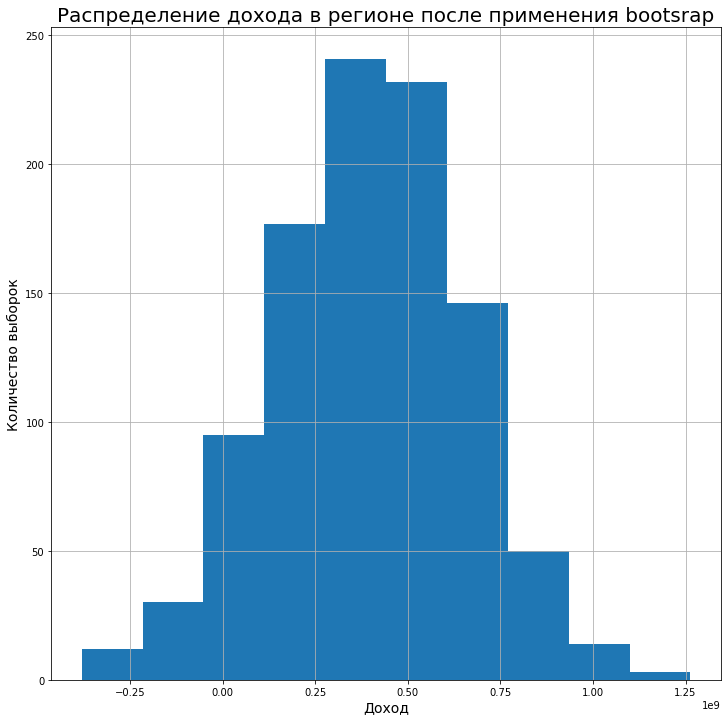

Средняя выручка: 399.58 млн. руб
Предполагаемые риски убытка 6.00%
2.5%-квантиль: -110.47 млн. руб
97.5%-квантиль: 897.46 млн. руб


In [35]:
bs(target_valid_0, predictions_0)

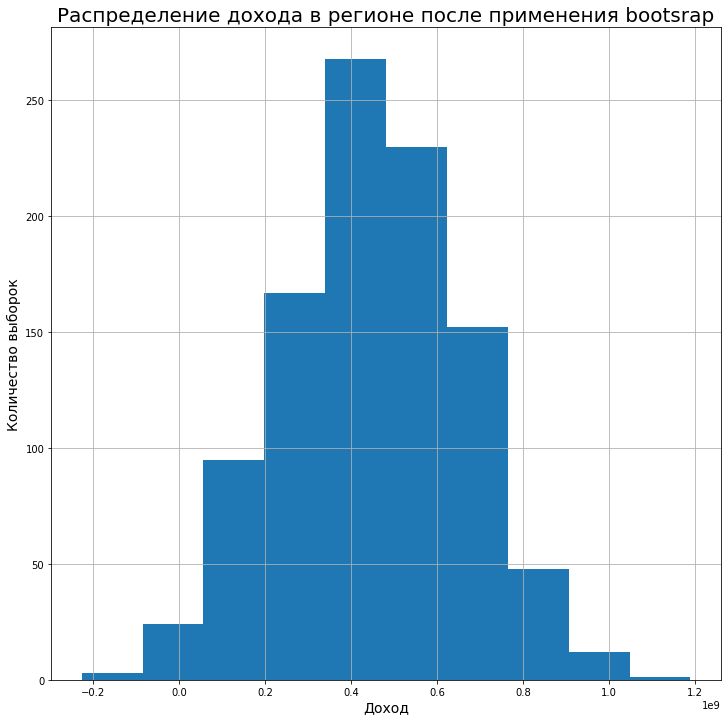

Средняя выручка: 452.58 млн. руб
Предполагаемые риски убытка 0.90%
2.5%-квантиль: 52.31 млн. руб
97.5%-квантиль: 830.15 млн. руб


In [36]:
bs(target_valid_1, predictions_1)

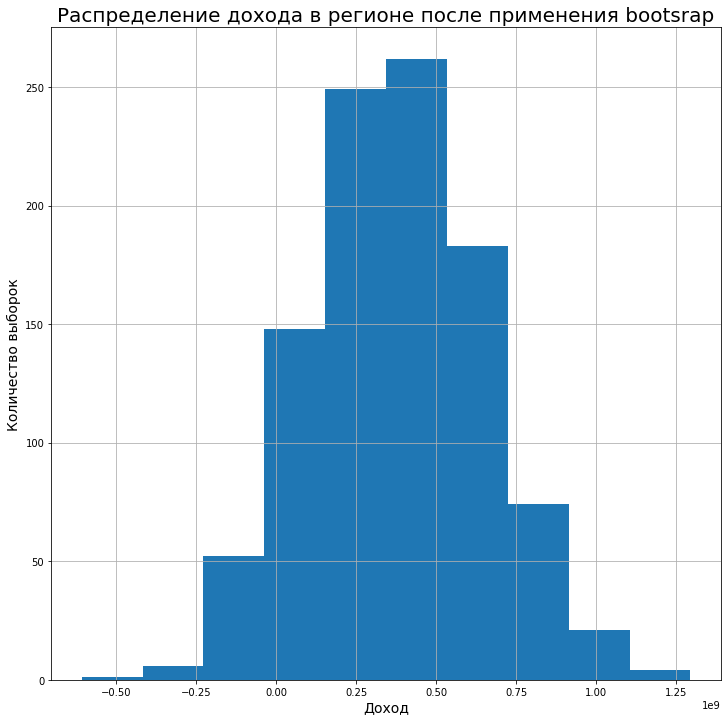

Средняя выручка: 378.71 млн. руб
Предполагаемые риски убытка 7.50%
2.5%-квантиль: -127.78 млн. руб
97.5%-квантиль: 907.92 млн. руб


In [37]:
bs(target_valid_2, predictions_2)

Удивительно, однако по результатам исследования самым прибыльным оказалось именно второе месторождение. Более того, показатели риска у этого месторождения ниже процента, тогда как у остальных риски составляют от 6 до 7.5%, а средня выручка значительно ниже. Доверительный интервал  находится "выше" нуля, однако его верхняя граница ниже максимально достигнутой.

**Вывод:**

На основании проведенного исследования предоставленных данных рекомендую выбрать для разработки учаток №2. При небольших рисках потенциальная прибыль с этого участка, согласно предсказаний модели, самая высокая, а доверительный интервал для средней прибыли с участка значительно "выше" нуля, в отличие от остальных предложенных к рассмотрению. Всё это позволяет с уверенностью утверждать, что разработка этого участка окажется наиболее выгодной для компании.